<a href="https://colab.research.google.com/github/Antares01/semester_project_ml_for_finance/blob/main/semester_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO:
add test options in and out of money
add log price as second input
try equally spaced distribution

In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
!pip install tf-quant-finance
import tf_quant_finance as tff 

option_price = tff.black_scholes.option_price


In [58]:
import numpy as np
import torch
from torch import nn
from scipy.stats import lognorm
from matplotlib import pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
from tqdm import tqdm

In [59]:
# option price generation parameters
TOT_OPTIONS = 1000
EXPIRY = 1.0
RATE = 0.0
SPOT = 100
STRIKE_MIN = 50
STRIKE_MAX = 150
VOLATILITY = 0.6

LAMBDA = SPOT / 3 # scaling factor for spot and strike
SPOT_SCALED = SPOT/LAMBDA
STRIKE_MIN_SCALED = STRIKE_MIN/LAMBDA
STRIKE_MAX_SCALED = STRIKE_MAX/LAMBDA
SCALED_VOLATILITY = VOLATILITY/LAMBDA

# NN parameters
MC_STEPS_STARTING = 2**8
MC_STEPS_FINAL = 2**14

EPOCHS = 100
batch_size = 16


#distribution parameters
PROPOSAL_SIGMA = SCALED_VOLATILITY #0.3/10 * 4 sigma should not be divided 
PROPOSAL_MU_SCALED = np.log(SPOT_SCALED) - 0.5 * PROPOSAL_SIGMA**2 
PROPOSAL_MU = np.log(SPOT) - 0.5 * VOLATILITY**2

#integration parameter
INTERVAL_LENGTH = 10
START_UNIF = 0.01

#Generate train and test data

In [60]:
"""
# Calculate discount factors (e^-rT)
rate = 0.05
expiries = np.array([0.5, 1.0, 2.0, 1.3])
discount_factors = np.exp(-rate * expiries)
# Current value of assets.
spots = np.array([0.9, 1.0, 1.1, 0.9])
# Forward value of assets at expiry.
forwards = spots / discount_factors
# Strike prices given by:
strikes = np.array([1.0, 2.0, 1.0, 0.5])
# Indicate whether options are call (True) or put (False)
is_call_options = np.array([True, True, False, False])
# The volatilites at which the options are to be priced.
volatilities = np.array([0.7, 1.1, 2.0, 0.5])
# Calculate the prices given the volatilities and term structure.
prices = option_price(
      volatilities=volatilities,
      strikes=strikes,
      expiries=expiries,
      forwards=forwards,
      discount_factors=discount_factors,
      is_call_options=is_call_options)
prices
"""

'\n# Calculate discount factors (e^-rT)\nrate = 0.05\nexpiries = np.array([0.5, 1.0, 2.0, 1.3])\ndiscount_factors = np.exp(-rate * expiries)\n# Current value of assets.\nspots = np.array([0.9, 1.0, 1.1, 0.9])\n# Forward value of assets at expiry.\nforwards = spots / discount_factors\n# Strike prices given by:\nstrikes = np.array([1.0, 2.0, 1.0, 0.5])\n# Indicate whether options are call (True) or put (False)\nis_call_options = np.array([True, True, False, False])\n# The volatilites at which the options are to be priced.\nvolatilities = np.array([0.7, 1.1, 2.0, 0.5])\n# Calculate the prices given the volatilities and term structure.\nprices = option_price(\n      volatilities=volatilities,\n      strikes=strikes,\n      expiries=expiries,\n      forwards=forwards,\n      discount_factors=discount_factors,\n      is_call_options=is_call_options)\nprices\n'

In [61]:
rates = np.array([RATE]*TOT_OPTIONS)
discount_factors = np.exp(- (rates)*EXPIRY)
spots = np.array([SPOT]*TOT_OPTIONS)
forwards = spots / discount_factors
strikes = np.linspace(STRIKE_MIN, STRIKE_MAX, TOT_OPTIONS) #[50., 60. , 75., 110., 125., 135. ]  #
is_call_options = np.random.choice(a=[False, True], size=(TOT_OPTIONS,)) #[True, True, True, False, False, False] #
volatilities = np.array([VOLATILITY]*TOT_OPTIONS)
expiries = np.array([EXPIRY]*TOT_OPTIONS)
prices = option_price(
      volatilities=volatilities,
      strikes=strikes,
      expiries=expiries,
      forwards=forwards,
      discount_factors=discount_factors,
      is_call_options=is_call_options)

In [62]:
prices

<tf.Tensor: shape=(1000,), dtype=float64, numpy=
array([ 2.53031587, 52.44990241,  2.56978166,  2.58965339, 52.20921739,
        2.62967493, 52.04922429, 51.96936702, 51.88960272,  2.71083234,
       51.73035326, 51.65086824, 51.57147645,  2.79347927, 51.41297284,
       51.33386114, 51.25484293,  2.87761998,  2.89888904,  2.92025177,
        2.94170823,  2.96325847, 50.78270036, 50.70433826,  3.02847251,
        3.05039847,  3.07241849, 50.39182992,  3.11674091, 50.23614052,
        3.16144019,  3.18393127,  3.2065167 , 49.92589323,  3.25197081,
       49.77133607,  3.29780287,  3.32086073,  3.34401321, 49.46335644,
       49.38659816, 49.30993461,  3.43757003, 49.15689184,  3.4849171 ,
        3.50873292,  3.53264364,  3.55664929,  3.58074991,  3.60494553,
       48.62423116, 48.54851676, 48.47289743, 48.3973732 , 48.32194411,
        3.75211568,  3.77697702,  3.80193357, 48.02117953,  3.85213235,
        3.87737463,  3.9027122 ,  3.92814507,  3.95367325, 47.57289037,
        4.00501

In [63]:
scaled_prices = np.array(prices/LAMBDA)

In [64]:
print(strikes)
print(is_call_options)

[ 50.          50.1001001   50.2002002   50.3003003   50.4004004
  50.5005005   50.6006006   50.7007007   50.8008008   50.9009009
  51.001001    51.1011011   51.2012012   51.3013013   51.4014014
  51.5015015   51.6016016   51.7017017   51.8018018   51.9019019
  52.002002    52.1021021   52.2022022   52.3023023   52.4024024
  52.5025025   52.6026026   52.7027027   52.8028028   52.9029029
  53.003003    53.1031031   53.2032032   53.3033033   53.4034034
  53.5035035   53.6036036   53.7037037   53.8038038   53.9039039
  54.004004    54.1041041   54.2042042   54.3043043   54.4044044
  54.5045045   54.6046046   54.7047047   54.8048048   54.9049049
  55.00500501  55.10510511  55.20520521  55.30530531  55.40540541
  55.50550551  55.60560561  55.70570571  55.80580581  55.90590591
  56.00600601  56.10610611  56.20620621  56.30630631  56.40640641
  56.50650651  56.60660661  56.70670671  56.80680681  56.90690691
  57.00700701  57.10710711  57.20720721  57.30730731  57.40740741
  57.50750751  57.60

In [65]:
scaled_prices

array([0.07590948, 1.57349707, 0.07709345, 0.0776896 , 1.56627652,
       0.07889025, 1.56147673, 1.55908101, 1.55668808, 0.08132497,
       1.5519106 , 1.54952605, 1.54714429, 0.08380438, 1.54238919,
       1.54001583, 1.53764529, 0.0863286 , 0.08696667, 0.08760755,
       0.08825125, 0.08889775, 1.52348101, 1.52113015, 0.09085418,
       0.09151195, 0.09217255, 1.5117549 , 0.09350223, 1.50708422,
       0.09484321, 0.09551794, 0.0961955 , 1.4977768 , 0.09755912,
       1.49314008, 0.09893409, 0.09962582, 0.1003204 , 1.48390069,
       1.48159794, 1.47929804, 0.1031271 , 1.47470676, 0.10454751,
       0.10526199, 0.10597931, 0.10669948, 0.1074225 , 0.10814837,
       1.45872693, 1.4564555 , 1.45418692, 1.4519212 , 1.44965832,
       0.11256347, 0.11330931, 0.11405801, 1.44063539, 0.11556397,
       0.11632124, 0.11708137, 0.11784435, 0.1186102 , 1.42718671,
       0.12015047, 1.4227267 , 0.12170219, 1.41827813, 1.41605814,
       1.41384101, 1.41162675, 1.40941535, 1.40720681, 1.40500

In [66]:
#scaled version
"""
spots_scaled = np.array([SPOT_SCALED]*TOT_OPTIONS)
forwards_scaled = spots_scaled / discount_factors
strikes_scaled = strikes/LAMBDA #[50., 60. , 75., 110., 125., 135. ]  #
prices_scaled = option_price(
      volatilities=volatilities,
      strikes=strikes_scaled,
      expiries=expiries,
      forwards=forwards_scaled,
      discount_factors=discount_factors,
      is_call_options=is_call_options)
      """

'\nspots_scaled = np.array([SPOT_SCALED]*TOT_OPTIONS)\nforwards_scaled = spots_scaled / discount_factors\nstrikes_scaled = strikes/LAMBDA #[50., 60. , 75., 110., 125., 135. ]  #\nprices_scaled = option_price(\n      volatilities=volatilities,\n      strikes=strikes_scaled,\n      expiries=expiries,\n      forwards=forwards_scaled,\n      discount_factors=discount_factors,\n      is_call_options=is_call_options)\n      '

In [69]:
# Jakob suggestion
"""
START_UNIF=0
INTERVAL_LENGTH=20
MC_STEPS=20000
coordinates=np.linspace(start=START_UNIF+INTERVAL_LENGTH/(2*MC_STEPS),stop=START_UNIF+INTERVAL_LENGTH-INTERVAL_LENGTH/(2*MC_STEPS),num=MC_STEPS)+np.random.uniform(low=-INTERVAL_LENGTH/(2*MC_STEPS),high=INTERVAL_LENGTH/(2*MC_STEPS),size=MC_STEPS)
coordinates = np.linspace(start = START_UNIF, stop = START_UNIF+INTERVAL_LENGTH, num=MC_STEPS / 2) + np.random(low = START_UNIF, high= START_UNIF+INTERVAL_LENGTH)
print(coordinates)
"""

'\nSTART_UNIF=0\nINTERVAL_LENGTH=20\nMC_STEPS=20000\ncoordinates=np.linspace(start=START_UNIF+INTERVAL_LENGTH/(2*MC_STEPS),stop=START_UNIF+INTERVAL_LENGTH-INTERVAL_LENGTH/(2*MC_STEPS),num=MC_STEPS)+np.random.uniform(low=-INTERVAL_LENGTH/(2*MC_STEPS),high=INTERVAL_LENGTH/(2*MC_STEPS),size=MC_STEPS)\ncoordinates = np.linspace(start = START_UNIF, stop = START_UNIF+INTERVAL_LENGTH, num=MC_STEPS / 2) + np.random(low = START_UNIF, high= START_UNIF+INTERVAL_LENGTH)\nprint(coordinates)\n'

In [70]:
from torch.utils.data import DataLoader
scaled_strikes = strikes / LAMBDA
prices_and_strikes = [ (scaled_prices[i], scaled_strikes[i], is_call_options[i]) for i in range(TOT_OPTIONS)]
target_dataloader = DataLoader(prices_and_strikes , batch_size=batch_size, shuffle = True)

## In and out of the money options for testing

In [84]:
STRIKE_IDM_MIN = 1
STRIKE_IDM_MAX = STRIKE_MIN

STRIKE_OTM_MIN = STRIKE_MAX 
STRIKE_OTM_MAX = 3*STRIKE_MAX

In [85]:
test_strikes = np.concatenate([np.linspace(STRIKE_IDM_MIN, STRIKE_IDM_MAX, TOT_OPTIONS//2), np.linspace(STRIKE_OTM_MIN, STRIKE_OTM_MAX, TOT_OPTIONS//2)]) 
test_prices = option_price(
      volatilities=volatilities,
      strikes=test_strikes,
      expiries=expiries,
      forwards=forwards,
      discount_factors=discount_factors,
      is_call_options=is_call_options)

In [87]:
test_prices_scaled = test_prices / LAMBDA

In [ ]:
test_strikes_scaled = test_strikes / LAMBDA
test_prices_and_strikes = [ (test_prices_scaled[i], test_strikes_scaled[i], is_call_options[i]) for i in range(TOT_OPTIONS)]
test_dataloader = DataLoader(prices_and_strikes , batch_size=batch_size, shuffle = True)

#Model and loss

In [71]:
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(1e-1),
            
            nn.Linear(128, 512),
            nn.LeakyReLU(1e-1),   

            nn.Linear(512, 128),
            nn.LeakyReLU(1e-1),
            
            nn.Linear(128, 1)
        )
        self.softplus = nn.Softplus()
        
    
    def forward(self, x):
        x = self.flatten(x)
        y = torch.log(x)
        x = self.linear_relu_stack(torch.cat((x,y), 1))
        x = self.softplus(x)
        return x


class LognormalNet(nn.Module):
  def __init__(self):
    super(LognormalNet, self).__init__()
    self.sigma = nn.Parameter(torch.Tensor([PROPOSAL_SIGMA]))
    self.mu = nn.Parameter(torch.Tensor([PROPOSAL_MU]))

  def forward(self, x):
    return 1/(x * self.sigma * np.sqrt(2* np.pi)) * torch.exp(-(torch.log(x) - self.mu)**2 / (2* self.sigma**2) )

In [72]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = BaselineNet().to(device)
print(model)

Using cpu device
BaselineNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (softplus): Softplus(beta=1, threshold=20)
)


In [73]:
class OptionLoss(nn.Module):
    def __init__(self, beta):
        super(OptionLoss,self).__init__()
        self.beta = beta
    
    # outputs the MC_STEPS predictions, labels the TOT_OPTIONS labels
    def forward(self, outputs, labels, strike, is_call, coordinates):
        loss = 0
        mc_integral = 0
        payoff = lambda  j :  torch.max(torch.zeros(MC_STEPS), coordinates - strike[j] ) if is_call[j] else torch.max(torch.zeros(MC_STEPS), strike[j] - coordinates)
        #densities_ratio = torch.div(outputs , torch.Tensor([lognorm.pdf(coordinates, PROPOSAL_SIGMA, 0, np.exp(PROPOSAL_MU)) ]))
        #print(outputs)
        densities = 1/INTERVAL_LENGTH #torch.Tensor([lognorm.pdf(coordinates, PROPOSAL_SIGMA, 0, np.exp(PROPOSAL_MU)) ])
        #print(densities_ratio)
        for j in range(len(labels)):
          numerator  = payoff(j)
          mc_price = numerator * outputs / densities
          #print(coordinates)
          #print(strikes[j])
          #print(numerator)
          #print(mc_price)
          #plt.scatter(coordinates,payoff(j))
          #plt.xlim(-1,20)
          #plt.ylim(-1,20)
          #print(payoff(j))
          #print(mc_price)
          #print(mc_price.sum() / MC_STEPS)
          loss += (labels[j] -  mc_price.sum() / MC_STEPS)**2
          #loss += (labels[j] - mc_price.sum() / MC_STEPS)**2

        
        """
        for i in range(MC_STEPS - 1):
          mc_integral += (coordinates[i+1] - coordinates[i])*(outputs[i+1] - outputs[i])
        """
        #print("custom loss is " + str(loss))
        #print("mc integral " + str(mc_integral))
        #print("integral loss is " + str(self.beta * (1 - 0.5*mc_integral)**2))
        return loss  #+ self.beta * (1 - 0.5*mc_integral)**2
            

In [74]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-20)
loss_fn = OptionLoss(0)

In [75]:
loss_history = []
for epoch in tqdm(range(EPOCHS)):
    for batch, (target_prices, strike_prices, is_call) in enumerate(target_dataloader):
        if epoch < EPOCHS * 0.5:
          MC_STEPS = MC_STEPS_STARTING
        elif epoch < EPOCHS * 0.75 :
          MC_STEPS = (MC_STEPS_STARTING + MC_STEPS_FINAL)//2
        else:
          MC_STEPS = MC_STEPS_FINAL
        #x = np.concatenate( [ np.linspace(start = START_UNIF, stop = START_UNIF+INTERVAL_LENGTH, num=MC_STEPS // 2) , np.random.uniform(low = START_UNIF, high= START_UNIF+INTERVAL_LENGTH, size=MC_STEPS//2) ] ) 
        #x = np.concatenate([ np.random.uniform(low = START_UNIF, high= START_UNIF+INTERVAL_LENGTH/10, size=MC_STEPS//4) , np.random.uniform(low = START_UNIF, high= START_UNIF+INTERVAL_LENGTH, size=MC_STEPS//2) , np.random.uniform(low = START_UNIF + 9*INTERVAL_LENGTH/10 , high= START_UNIF+INTERVAL_LENGTH, size=MC_STEPS//4) ])
        #x = np.expand_dims(x, axis = 1)
        #X = torch.Tensor(x) #coordinates are not sorted
        X = torch.zeros(MC_STEPS, 1).to(device)
        X.uniform_(START_UNIF, INTERVAL_LENGTH)
        #X.log_normal_(PROPOSAL_MU, PROPOSAL_SIGMA )
        #print(X)
        pred = model(X)
        loss = loss_fn(pred.cpu().squeeze(), target_prices, strike_prices, is_call, X.cpu().squeeze())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-1)
        optimizer.step()
    loss_history.append(float(loss))


100%|██████████| 100/100 [11:04<00:00,  6.64s/it]


In [76]:
# EXPERIMENT 
i = 0
X = torch.zeros(MC_STEPS)
X.log_normal_(PROPOSAL_MU, PROPOSAL_SIGMA)
X = np.array(X)
#prices[i], strikes[i], is_call_options[i]
#payoff =   np.maximum(np.zeros(MC_STEPS), X - strikes[i] ) if is_call_options[i] else np.maximum(np.zeros(MC_STEPS), strikes[i] - X)
#print( ( prices[i] - (payoff.sum() / MC_STEPS))**2 )

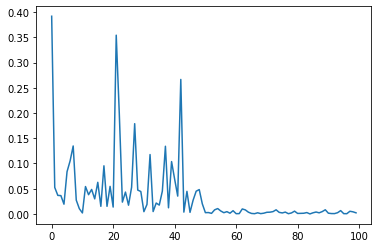

In [77]:
plt.plot(range(len(loss_history)), loss_history)
#plt.ylim(bottom=-0.0001,top=100)

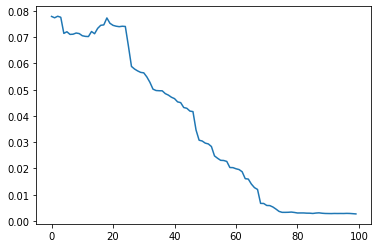

In [78]:
running_loss_average = uniform_filter1d(loss_history, size=50)
plt.plot(range(len(running_loss_average)), running_loss_average)

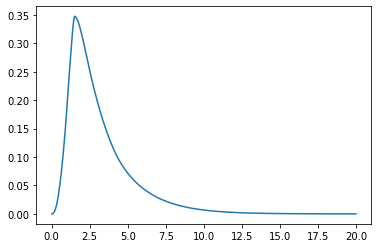

In [79]:
x = torch.Tensor(np.arange(0.001, 20, 0.01)).to(device).unsqueeze(-1)
p = model(x)
plt.plot(x.cpu().detach().numpy(), p.cpu().detach().numpy())

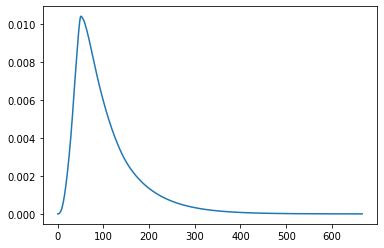

In [80]:
x = torch.Tensor(np.arange(0.001, 20 , 0.01)).to(device).unsqueeze(-1)
p = model(x) 
plt.plot(x.cpu().detach().numpy() * LAMBDA, p.cpu().detach().numpy() / LAMBDA)

In [81]:
p

tensor([[2.6986e-08],
        [6.3337e-06],
        [2.7657e-05],
        ...,
        [4.8589e-05],
        [4.8346e-05],
        [4.8105e-05]], grad_fn=<SoftplusBackward0>)

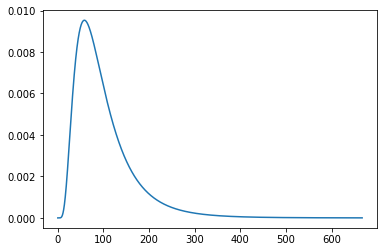

In [82]:
x = np.linspace(0.0001, 20 * LAMBDA, num = 10000)
y = lognorm.pdf(x , s=VOLATILITY, loc=0, scale=np.exp(PROPOSAL_MU))
plt.plot(x, y)

In [83]:
for para in model.parameters():
    print(para)

Parameter containing:
tensor([[ 0.3924, -0.0520],
        [-0.4382,  0.5072],
        [ 0.5879, -0.2037],
        [-0.6885, -0.4694],
        [ 0.3131, -0.5247],
        [-0.2205,  0.4511],
        [ 0.2582, -0.3685],
        [-0.5883, -0.0175],
        [-0.3007, -0.7132],
        [-0.4444, -0.4069],
        [-0.3612, -0.0397],
        [-0.6351,  0.1790],
        [-0.0941, -0.0873],
        [ 0.5488, -0.1568],
        [-0.1275, -0.0265],
        [-0.5254, -0.3291],
        [-0.6538, -0.5921],
        [-0.5172, -0.1135],
        [ 0.5656, -0.4541],
        [-0.2040,  0.5975],
        [ 0.2104, -0.2335],
        [-0.1811, -0.2571],
        [ 0.3693, -0.2373],
        [ 0.0995, -0.6678],
        [-0.0930, -0.6426],
        [ 0.1414,  0.0205],
        [-0.4014,  0.3807],
        [ 0.2765,  0.6322],
        [ 0.4270, -0.1910],
        [-0.2789, -0.7187],
        [-0.4634, -0.5306],
        [-0.6267,  0.7359],
        [-0.2111, -0.1033],
        [ 0.3414,  0.3061],
        [ 0.3240,  0.2578]

#Testing

In [88]:
with torch.no_grad():
  total_loss = 0
  for batch, (target_prices, strike_prices, is_call) in enumerate(target_dataloader):
          MC_STEPS = MC_STEPS_FINAL
          X = torch.zeros(MC_STEPS, 1).to(device)
          X.uniform_(0.01, INTERVAL_LENGTH)
          pred = model(X)
          loss = loss_fn(pred.cpu().squeeze(), target_prices, strike_prices, is_call, X.cpu().squeeze())
          total_loss += loss        

In [90]:
print(total_loss)

tensor(0.1871, dtype=torch.float64)


In [89]:
print(total_loss/TOT_OPTIONS)

tensor(0.0002, dtype=torch.float64)
